# Classification

## Setup

### Install/import libraries
As usual, remember to use a virtual environment!

### Download data
You can download the EMNIST dataset from the official website. Make sure to provide clear instructions on how to download and extract the data.

### Define helper functions 
It's a good idea to preprocess the data to make it easier to work with. You can create subsets of the data for training, validation, and testing. Also, since the labels in the original dataset are encoded as integers, it may be helpful to create a dictionary that maps the integer labels to their corresponding characters.

## Example: Classify 0 vs 1

### Pre-built models classifying 0/1
 - Logistic regression
 - RandomForest
 - XGBoost
 - Neural network

### Evaluate/compare model performance
 - Confusion matrix: A table that shows the number of true positives, true negatives, false positives, and false negatives for a binary classification problem.
 - Accuracy: The proportion of correct predictions over the total number of predictions.
 - Precision: The proportion of true positives over the total number of positive predictions.
 - Recall: The proportion of true positives over the total number of actual positives.
 - F1 score: The harmonic mean of precision and recall, which balances both metrics and gives equal weight to both.

In [1]:
# Install required packages (once per virtual environment)
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow xgboost
%reset -f

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emnist
from IPython.display import display, Markdown


# ML packages
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Constants
SIZE = 28
REBUILD = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # or 3 to suppress all warnings


2024-02-04 20:59:56.862584: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Display metrics for a model
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=['actual 0', 'actual 1'], columns=['predicted 0', 'predicted 1'])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    display(cm_df)

In [4]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
train['image'] = list(image)
train['image_flat'] = train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
valid = pd.DataFrame()
valid['image'] = list(image)
valid['image_flat'] = valid['image'].apply(lambda x: np.array(x).reshape(-1))
valid['label'] = label
valid['class'] = class_label

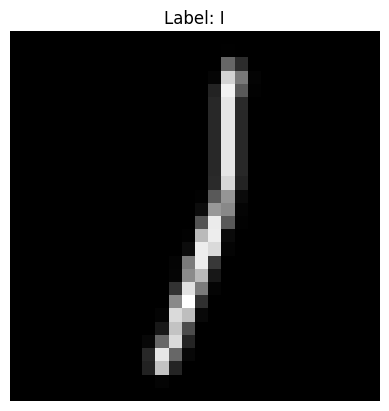

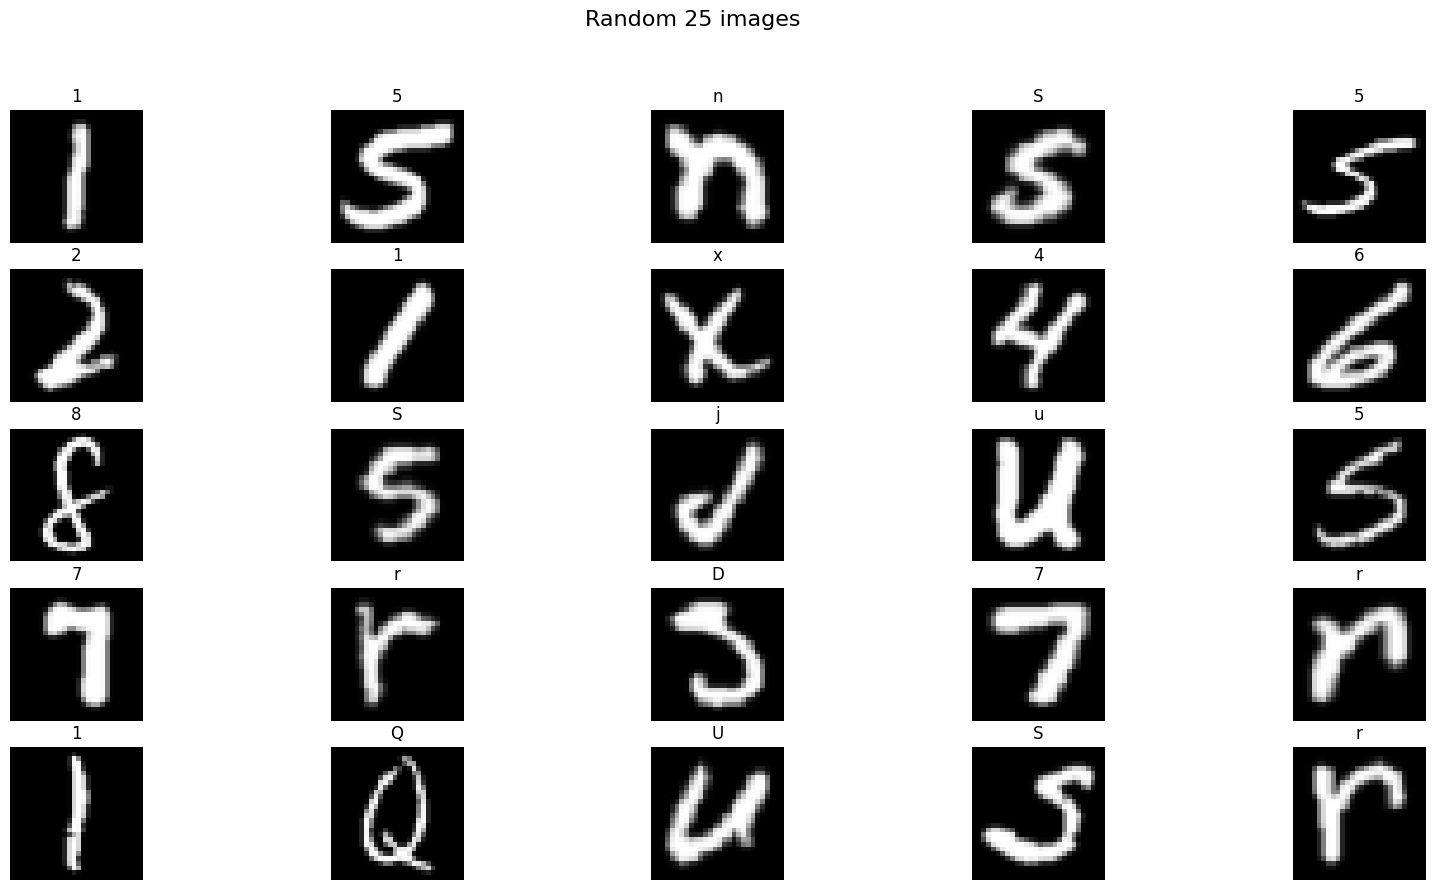

In [5]:
# Using the helper functions

# Plot a random image from the training set
index = np.random.randint(0, len(train))
show_image(train.iloc[index])

# Show a random set of 25 images in a 5x5 grid
show_grid(train.sample(25), title='Random 25 images')

# Show the first 25 images in a 5x5 grid
# show_grid(train[:25], title='First 25 images')

# Isn't it nice to have a helper function to do this for you?


In [6]:
# 0 vs 1 Classifier: Subset the data

# Subset `train` and `valid` to only include 0s and 1s
symbols_list = ['0', '1']

mask_train = train['class'].apply(lambda x: x in symbols_list)
train_01 = train[mask_train]
train_01.reset_index(drop=True, inplace=True)

mask_valid = valid['class'].apply(lambda x: x in symbols_list)
valid_01 = valid[mask_valid]
valid_01.reset_index(drop=True, inplace=True)



# Create a dictionary for performance metrics
metrics_dict = {}

# show_grid(train_01[:25], title="First 25 images of 0's and 1's")


In [7]:
# (OPTIONAL) We can define all the metrics we want to track in a dictionary
metrics_dict = {
    '0_vs_1' : { # task name (0 vs 1 classifier)
        'logistic_regression': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [8]:
# 0 vs 1 Classifier: RandomForest
task = '0_vs_1'
model_name = 'random_forest'
metrics_dict[task] = {model_name: {}}

# Initialize random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
rf_clf.fit(train_01['image_flat'].tolist(), train_01['label'])
y_pred = rf_clf.predict(valid_01['image_flat'].tolist())

# Calculate performance metrics
acc = accuracy_score(valid_01['label'], y_pred)
prec = precision_score(valid_01['label'], y_pred)
rec = recall_score(valid_01['label'], y_pred)
f1 = f1_score(valid_01['label'], y_pred)
cm = confusion_matrix(valid_01['label'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: random_forest

,accuracy,precision,recall,f1
0,0.999257,0.998738,0.999842,0.999289


# Confusion Matrix: random_forest

,predicted 0,predicted 1
actual 0,5770,8
actual 1,1,6329


In [9]:
# 0 vs 1 Classifier: Logistic Regression 
task = '0_vs_1'
model_name = 'logistic_regression'

# Initialize logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Scale the data
# When running without scaling the data, the model does not converge
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_01['image_flat'].tolist())
valid_scaled = scaler.transform(valid_01['image_flat'].tolist())

# Initialize logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Train and evaluate model
lr_clf.fit(train_scaled, train_01['label'])
y_pred = lr_clf.predict(valid_scaled)

# Calculate performance metrics
acc = accuracy_score(valid_01['label'], y_pred)
prec = precision_score(valid_01['label'], y_pred)
rec = recall_score(valid_01['label'], y_pred)
f1 = f1_score(valid_01['label'], y_pred)
cm = confusion_matrix(valid_01['label'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: logistic_regression

,accuracy,precision,recall,f1
0,0.997027,0.995903,0.99842,0.99716


# Confusion Matrix: logistic_regression

,predicted 0,predicted 1
actual 0,5752,26
actual 1,10,6320


In [10]:
# 0 vs 1 Classifier: XGBoost
task = '0_vs_1'
model_name = 'xgboost'

# Initialize XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
xgb_clf.fit(train_01['image_flat'].tolist(), train_01['label'])
y_pred = xgb_clf.predict(valid_01['image_flat'].tolist())

# Calculate performance metrics
acc = accuracy_score(valid_01['label'], y_pred)
prec = precision_score(valid_01['label'], y_pred)
rec = recall_score(valid_01['label'], y_pred)
f1 = f1_score(valid_01['label'], y_pred)
cm = confusion_matrix(valid_01['label'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)


# Performance Metrics: xgboost

,accuracy,precision,recall,f1
0,0.999422,0.99921,0.999684,0.999447


# Confusion Matrix: xgboost

,predicted 0,predicted 1
actual 0,5773,5
actual 1,2,6328


Epoch 1/10
2280/2280 [==============================] - 5s 2ms/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 0.0013 - val_accuracy: 0.9997
Epoch 2/10
2280/2280 [==============================] - 4s 2ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0020 - val_accuracy: 0.9996
Epoch 3/10
2280/2280 [==============================] - 5s 2ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0043 - val_accuracy: 0.9991
Epoch 4/10
2280/2280 [==============================] - 5s 2ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0013 - val_accuracy: 0.9998
Epoch 5/10
2280/2280 [==============================] - 5s 2ms/step - loss: 7.0608e-04 - accuracy: 0.9997 - val_loss: 0.0016 - val_accuracy: 0.9997
Epoch 6/10
2280/2280 [==============================] - 5s 2ms/step - loss: 5.0647e-04 - accuracy: 0.9998 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 7/10
2280/2280 [==============================] - 5s 2ms/step - loss: 6.6294e-04 - accuracy: 0.9998 - val_loss: 8.3385e-04

# Performance Metrics: neural_network

,accuracy,precision,recall,f1
0,0.999257,0.99858,1.0,0.99929


# Confusion Matrix: neural_network

,predicted 0,predicted 1
actual 0,5769,9
actual 1,0,6330


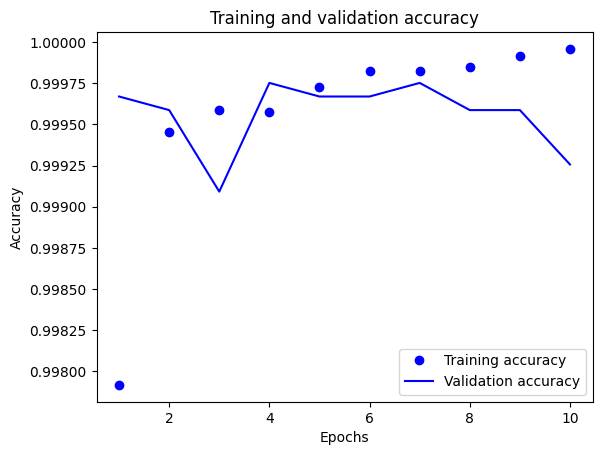

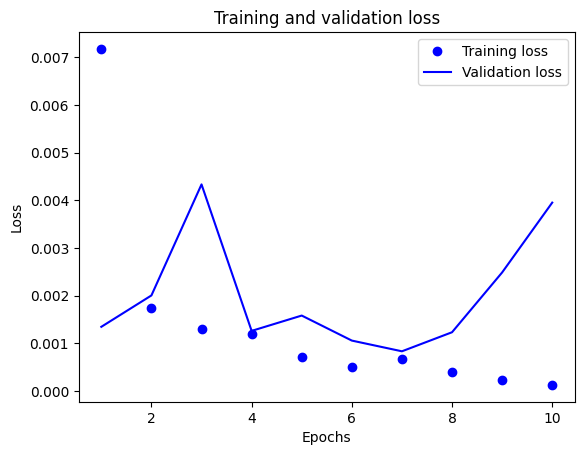

In [11]:
# 0 vs 1 Classifier: Neural Network
task = '0_vs_1'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)

# Convert data to tensor
train_images = np.array(train_01['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images)))
train_images = train_images / 255.0
train_labels = np.array(train_01['label'])
valid_images = np.array(valid_01['image'])
valid_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), valid_images)))
valid_images = valid_images / 255.0
valid_labels = np.array(valid_01['label'])

# Initialize neural network model
model = Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model, specifying the optimizer, loss function, and metrics 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model, saving the history of the training process
history = model.fit(train_images, train_labels, epochs=10, validation_data=(valid_images, valid_labels))

# Evaluate the model
loss, acc = model.evaluate(valid_images, valid_labels)
y_pred = (model.predict(valid_images) > 0.5).astype(int).flatten()

# Calculate performance metrics
prec = precision_score(valid_labels, y_pred)
rec = recall_score(valid_labels, y_pred)
f1 = f1_score(valid_labels, y_pred)
cm = confusion_matrix(valid_labels, y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Plot the training and validation accuracy during the training of the model
plot_accuracy(history)
plot_loss(history)

In [12]:
# Show the performance metrics for all models as a raw dictionary

if not REBUILD:
    metrics_dict['0_vs_1']['xgboost'] = {
                                          'accuracy': 0.9994218698381235,
                                         'precision': 0.999210484762356,
                                            'recall': 0.9996840442338073,
                                                'f1': 0.9994472084024323,
                                  'confusion_matrix': [[5773,    5],
                                                       [   2, 6328]]
                                          }
    metrics_dict['0_vs_1']['random_forest'] = {
                                          'accuracy': 0.9992566897918731,
                                         'precision': 0.9987375729840618,
                                            'recall': 0.9998420221169037,
                                                'f1': 0.9992894923817794,
                                  'confusion_matrix': [[5770,    8],
                                                      [   1, 6329]]
                                                 }
    metrics_dict['0_vs_1']['logistic_regression'] = {
                                          'accuracy': 0.9972745292368682,
                                         'precision': 0.9965305156915313,
                                            'recall': 0.9982622432859399,
                                                'f1': 0.9973956278115382,
                                  'confusion_matrix': [[5756,   22],
                                                       [  11, 6319]]
                                                 }
    metrics_dict['0_vs_1']['neural_network'] = {
                                          'accuracy': 0.9995870590209961,
                                         'precision': 0.9992107340173638,
                                            'recall': 1.0,
                                                'f1': 0.9996052112120015,
                                  'confusion_matrix': [[5773,    5],
                                                       [   0, 6330]]
                                          }

display(metrics_dict)


{'0_vs_1': {'random_forest': {'accuracy': 0.9992566897918731,
   'precision': 0.9987375729840618,
   'recall': 0.9998420221169037,
   'f1': 0.9992894923817794,
   'confusion_matrix': array([[5770,    8],
          [   1, 6329]])},
  'logistic_regression': {'accuracy': 0.9970267591674926,
   'precision': 0.9959029309801449,
   'recall': 0.9984202211690363,
   'f1': 0.9971599873777217,
   'confusion_matrix': array([[5752,   26],
          [  10, 6320]])},
  'xgboost': {'accuracy': 0.9994218698381235,
   'precision': 0.999210484762356,
   'recall': 0.9996840442338073,
   'f1': 0.9994472084024323,
   'confusion_matrix': array([[5773,    5],
          [   2, 6328]])},
  'neural_network': {'accuracy': 0.9992566704750061,
   'precision': 0.9985802176999526,
   'recall': 1.0,
   'f1': 0.9992896045465309,
   'confusion_matrix': array([[5769,    9],
          [   0, 6330]])}}}

In [13]:
# create an empty DataFrame to hold the results
results_df = pd.DataFrame()

# iterate over the keys in the metrics_dict
for key in metrics_dict:
    
    # create a new DataFrame to hold the results for this key
    df = pd.DataFrame.from_dict(metrics_dict[key], orient='index')
    
    # add a new row to the DataFrame indicating the model name and metric type
    df = df.assign(model=key, metric=df.index)
    
    # set the index to the 'model' and 'metric' columns
    df = df.set_index(['model', 'metric'])
    
    # append the results to the main DataFrame
    results_df = pd.concat([results_df, df])

# display the resulting table
display(results_df)


accuracy  precision    recall        f1  \
model  metric                                                         
0_vs_1 random_forest        0.999257   0.998738  0.999842  0.999289   
       logistic_regression  0.997027   0.995903  0.998420  0.997160   
       xgboost              0.999422   0.999210  0.999684  0.999447   
       neural_network       0.999257   0.998580  1.000000  0.999290   

                                    confusion_matrix  
model  metric                                         
0_vs_1 random_forest          [[5770, 8], [1, 6329]]  
       logistic_regression  [[5752, 26], [10, 6320]]  
       xgboost                [[5773, 5], [2, 6328]]  
       neural_network         [[5769, 9], [0, 6330]]

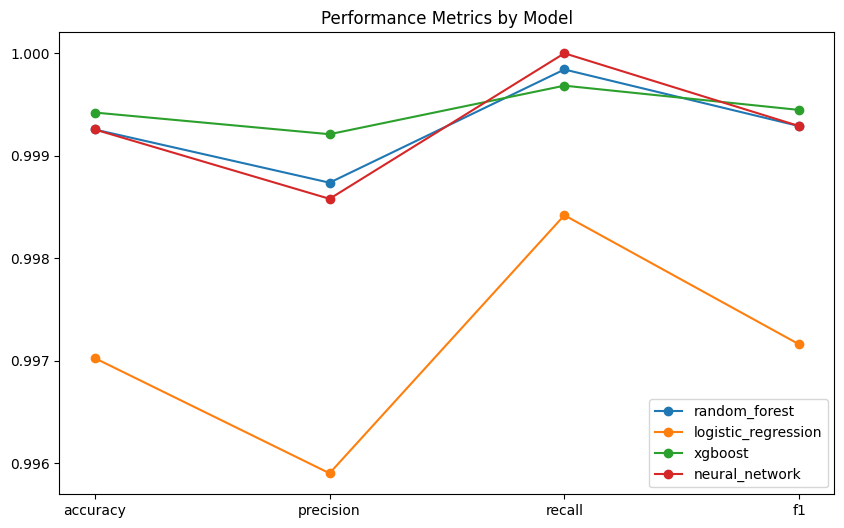

In [14]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# set the x-axis labels
labels = ['accuracy', 'precision', 'recall', 'f1']

# iterate over the models in the metrics_dict
for i, model in enumerate(metrics_dict['0_vs_1'].keys()):
    # extract the metric values for this model
    values = [metrics_dict['0_vs_1'][model][label] for label in labels]
    
    # plot the values as a line
    ax.plot(labels, values, label=model, marker='o', color=colors[i])

    
# add a legend and title
ax.legend()
ax.set_title('Performance Metrics by Model')

# show the plot
plt.show()


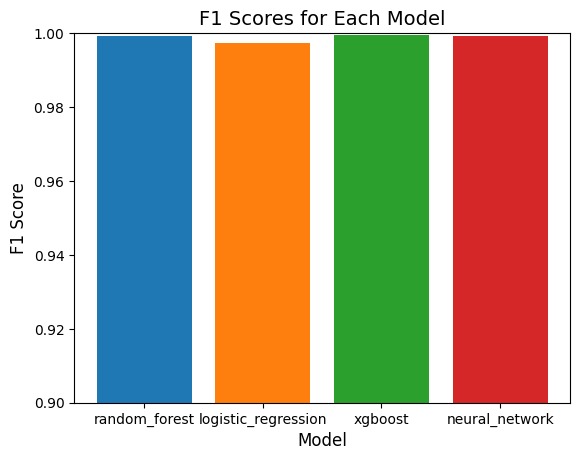

In [15]:
models = ['random_forest', 'logistic_regression', 'xgboost', 'neural_network']
accuracies = [metrics_dict['0_vs_1'][model]['f1'] for model in models]

plt.bar(models, accuracies, color=colors)
plt.title('F1 Scores for Each Model', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim([0.9, 1.0])
plt.show()
